In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import tensorflow as tf

In [2]:
from keras.models import Model,Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.regularizers import l1
from tensorflow.keras.layers import BatchNormalization
import os
import seaborn as sns

In [3]:
# Avoid OOM errors by setting GPU Memory Comsumption Growth 
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
print(os.listdir("C:\\Users\\a2-coutodeoliv\\OneDrive - UWE Bristol\\Images\\RF_CNN_img\\RF_CNN_img"))

['test', 'train', 'val']


In [5]:
size = 600

In [6]:
train_images = []
train_labels = []
for directory_path in glob.glob("C:\\Users\\a2-coutodeoliv\\OneDrive - UWE Bristol\\Images\\RF_CNN_img\\RF_CNN_img\\train\\*"):
    label = directory_path.split("\\")[-1]
    
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (size,size))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

In [7]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [8]:
test_images = []
test_labels = []

for directory_path in glob.glob("C:\\Users\\a2-coutodeoliv\\OneDrive - UWE Bristol\\Images\\RF_CNN_img\\RF_CNN_img\\test\\*"):
    new_label = directory_path.split("\\")[-1]
    
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (size,size))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(new_label)
        
        
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [9]:
#Encode labels from Text to int
from sklearn import preprocessing 

In [10]:
label_e = preprocessing.LabelEncoder()
label_e.fit(test_labels)
test_labels_encoded = label_e.transform(test_labels)
label_e.fit(train_labels)
train_labels_encoded = label_e.transform(train_labels)

In [11]:
#Split data into test and train datasets 
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [12]:
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0



In [13]:
from keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)


In [14]:
model = Sequential()
model.add(Conv2D(8, (3,3),(2, 2), activation='relu', input_shape=(600,600,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(16, (3,3), (2, 2), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(8, (3,3), (2, 2), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))


model.add(Flatten())

x = model.output
x = Dense(2, activation ='linear', activity_regularizer=l1(0.001))(x)
prediction_layer = Dense(1,activation='sigmoid')(x)


In [15]:
X_for_RF = model.predict(x_train)

#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

# Train the model on training data
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

#Send test data through same feature extractor process
X_test_feature = model.predict(x_test)
#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(X_test_feature)
#Inverse le transform to get original label back. 
prediction_RF_1 = label_e.inverse_transform(prediction_RF)


18/18 [==============================] - 4s 143ms/step


Accuracy =  0.6405693950177936
[[144 113]
 [ 89 216]]
Precision: 0.6565349544072948
Recall: 0.7081967213114754
F05: 0.6662553979025292
AxesSubplot(0.125,0.125;0.62x0.755)


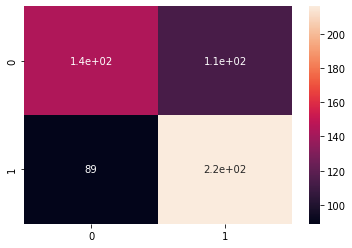

In [17]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score,accuracy_score,roc_auc_score

print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF_1))


#Confusion Matrix - verify accuracy of each class
cm = confusion_matrix(test_labels, prediction_RF_1)
precision = precision_score(y_test, prediction_RF)
recall = recall_score(y_test, prediction_RF)
f05=(1.25 * precision * recall) / (0.25 * precision + recall)
print(cm)
print("Precision:",precision)
print("Recall:", recall)
print("F05:", f05)
print(sns.heatmap(cm, annot= True))
